# Image restauration

Images restauration is the idea of recovery and **original** image from a **degradated** image knowing before hand the process of degradation. The recovered image is called **restaurated**.

Let $F$ a matrix that represent the original photo (with $f$ a line, array, of the image), $G$ the degradated image (with $g$ a line) and $\hat F$ the restaurated image. The degradation process is an uniform horizontal movement.

$$
g_i = (f_i + f_{i + 1} + ... + f_{i + n - 1})/n
$$

Let $H$ a matrix that represent the movement so $g = Hf$.

$$
G = H*F = \begin{bmatrix}
h_1 & \dots & h_n & 0 & 0 & 0 &  0 \\
0 & h_1 & \dots & h_n  & 0 & 0 & 0 \\
& & \vdots   & &   \vdots \\
0 & 0 & \dots & h_1 & \dots & h_n 
\end{bmatrix} 
\begin{bmatrix}
f_1 \\
f_2 \\
\vdots \\
f_n
\end{bmatrix} =
\begin{bmatrix}
g_1 \\
g_2 \\
\vdots \\
g_n
\end{bmatrix} 
$$

So, if $M$ is the number of colllums of $F$ and $n$ is the displacement, then the number of collums $N$ of $G$ is $N = M - n + 1$

## Libraries

In [55]:
from IPython.display import display
import numpy as np
from PIL import Image

## Create $G$

### Get the original image

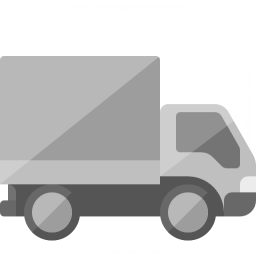

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]] (256, 256)


In [56]:
img = Image.open('./data/original.png').convert('L')
display(img)

F = np.asarray(img)
print(F, F.shape)


### Create the model

In [57]:
n = 100
H = []
M = len(F[0])
N = M - n +1
for i in range(N):
    row = [0] * M 
    
    for j in range(i, i + n):
        if (j < M): row[j] = 1/n
        
    H.append(row)
    
H = np.matrix(H)
print(H, H.shape)

[[0.01 0.01 0.01 ... 0.   0.   0.  ]
 [0.   0.01 0.01 ... 0.   0.   0.  ]
 [0.   0.   0.01 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.01 0.   0.  ]
 [0.   0.   0.   ... 0.01 0.01 0.  ]
 [0.   0.   0.   ... 0.01 0.01 0.01]] (157, 256)


### Generate G

In [58]:
G = H@F
G = (G - np.min(G)) / (np.max(G) - np.min(G)) * 255
G = G.astype('uint8')
N = len(G)

print(G, G.shape)
print(f"M = {M} N = {N}")

[[196 194 194 ... 254 255 255]
 [195 193 192 ... 254 255 255]
 [194 192 191 ... 254 255 255]
 ...
 [189 180 176 ... 173 182 196]
 [190 182 178 ... 174 182 196]
 [191 183 179 ... 174 182 196]] (157, 256)
M = 256 N = 157


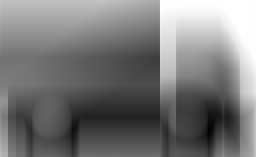

In [59]:
Image.fromarray(G, 'L').show()

# Get $\hat F$

Let's assume that the last row of $F$ is known with value of $x$.Then, we have

$$
G = H*F = \begin{bmatrix}
h_1 & \dots & h_n & 0 & 0 & 0 &  0 \\
0 & h_1 & \dots & h_n  & 0 & 0 & 0 \\
& & \vdots   & &   \vdots \\
0 & 0 & \dots & h_1 & \dots & h_n 
\end{bmatrix} 
\begin{bmatrix}
f_1 \\
f_2 \\
\vdots \\
x
\end{bmatrix} =
\begin{bmatrix}
g_1 \\
g_2 \\
\vdots \\
g_n
\end{bmatrix} 
$$


$$
\hat F = G * H^-1
$$


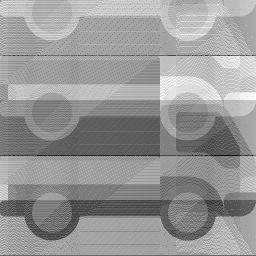

In [60]:
f_M = [1]*M
# Remove the Mth column from H
H_ = np.delete(H, M-1, axis=1)

# Subtract h_M * f_M from G
G_ = G - H[:, M-1] * f_M

# Solve for the unknown vector
f_hat_ = np.linalg.pinv(H_).dot(G_)
f_hat_ = np.concatenate([f_hat_[:M-1], [f_M], f_hat_[M-1:]])

f_hat_ = (f_hat_ - np.min(f_hat_)) / (np.max(f_hat_) - np.min(f_hat_)) * 255
f_hat_ = f_hat_.astype('uint8')
Image.fromarray(f_hat_, 'L').show()